<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/automl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-06-02 16:00:47--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>] 352.02K  --.-KB/s    in 0.004s  

2022-06-02 16:00:47 (77.4 MB/s) - ‘train.csv.2’ saved [360467/360467]

--2022-06-02 16:00:48--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: 

In [ ]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [ ]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
#idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
#df_treino= df_treino.reindex(idx)
dfx = df_treino[['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room']].resample('H').mean().iloc[1: , ]
df_treino = pd.DataFrame(dfx, columns = ['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room'])
df_treino.fillna(method='ffill', inplace=True)

In [ ]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 12:00:00', freq='H'),
 Timestamp('2012-04-11 06:00:00', freq='H'))

In [ ]:
df_treino.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 691 entries, 2012-03-13 12:00:00 to 2012-04-11 06:00:00
Freq: H
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CO2_room                          691 non-null    float64
 1   Relative_humidity_room            691 non-null    float64
 2   Lighting_room                     691 non-null    float64
 3   Outdoor_relative_humidity_Sensor  691 non-null    float64
 4   Indoor_temperature_room           691 non-null    float64
dtypes: float64(5)
memory usage: 32.4 KB


In [ ]:
dfx = pd.DataFrame(df_treino).reset_index()
dfx['data'] =  dfx['data_hora'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfx.groupby('data')['data_hora'].count().reset_index().sort_values('data')

,data,data_hora
0,2012-03-13,12
1,2012-03-14,24
2,2012-03-15,24
3,2012-03-16,24
4,2012-03-17,24
5,2012-03-18,24
6,2012-03-19,24
7,2012-03-20,24
8,2012-03-21,24
9,2012-03-22,24


In [ ]:
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-03-13"]
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-04-11"]

In [ ]:
df_treino.head(5)

,CO2_room,Relative_humidity_room,Lighting_room,Outdoor_relative_humidity_Sensor,Indoor_temperature_room
data_hora,,,,,
2012-03-14 00:00:00,224.91450,43.156650,13.232500,57.775325,19.290175
2012-03-14 01:00:00,225.70925,43.221325,13.175500,57.902000,18.657825
2012-03-14 02:00:00,226.18150,43.164000,13.423475,57.386000,18.035150
2012-03-14 03:00:00,219.42150,42.998000,13.346675,56.443300,17.412825
2012-03-14 04:00:00,214.63725,42.787325,13.179850,56.068675,16.817650


In [ ]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(600, 5) (72, 5)
2012-03-14 00:00:00 2012-04-07 23:00:00
2012-04-08 00:00:00 2012-04-10 23:00:00


In [ ]:
scaler = MinMaxScaler()
treino_values = scaler.fit_transform(dfTreino[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
teste_values = scaler.fit_transform(dfTeste[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
dfTreino_tmp = pd.DataFrame(treino_values, columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'] )
dfTreino = dfTreino[['Indoor_temperature_room']]
for c in dfTreino_tmp.columns:
  dfTreino[c] = dfTreino_tmp[c].tolist()
 
dfTeste_tmp = pd.DataFrame(teste_values,  columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'])
dfTeste = dfTeste[['Indoor_temperature_room']]
for c in dfTeste_tmp.columns:
  dfTeste[c] = dfTeste_tmp[c].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
dfTreino.head(3)

,Indoor_temperature_room,Relative_humidity_room,CO2_room,Outdoor_relative_humidity_Sensor,Lighting_room
data_hora,,,,,
2012-03-14 00:00:00,19.290175,0.406682,0.089145,0.574361,0.005741
2012-03-14 01:00:00,18.657825,0.408666,0.091149,0.576465,0.005304
2012-03-14 02:00:00,18.035150,0.406907,0.092340,0.567895,0.007205


In [ ]:
#stepwise_fit = auto_arima(dfTreino[['Indoor_temperature_room']], start_p=2, start_q=2,
#                          max_p=2, max_q=2, m=24,
#                          seasonal=True,
#                          d=None, trace=True,
#                          error_action='ignore',   
#                          suppress_warnings=True,  
#                          stepwise=True)

In [ ]:
modelo1 = SARIMAX(dfTreino['Indoor_temperature_room'],order=(2,1,2),seasonal_order=(1,0,1,24))
resultado1 = modelo1.fit()
resultado1.summary()




/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:              Indoor_temperature_room   No. Observations:                  600
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 24)   Log Likelihood                 251.876
Date:                              Thu, 02 Jun 2022   AIC                           -489.753
Time:                                      16:01:01   BIC                           -458.986
Sample:                                  03-14-2012   HQIC                          -477.775
                                       - 04-07-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6983      0.036     46.618      0.000       1.627       1.770
ar.L2         -0.7311      0.031    -23.613      0.000      -0.792      -0.670
ma.L1         -0.7975      0.052    -15.441      0.000      -0.899      -0.696
ma.L2         -0.1406      0.028     -5.036      0.000      -0.195      -0.086
ar.S.L24       0.9890      0.006    165.058      0.000       0.977       1.001
ma.S.L24      -0.8634      0.037    -23.512      0.000      -0.935      -0.791
sigma2         0.0238      0.001     43.403      0.000       0.023       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16818.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
previsoes1 = resultado1.predict(start=dfTeste.index.min(), end=dfTeste.index.max(), dynamic=False, typ='levels')
dfTeste['previsoes'] = previsoes1
#previsoes1.index = dfTeste.index
#previsoes1['Indoor_temperature_room']=dfTeste['Indoor_temperature_room']

#previsoes1.head(10)

In [ ]:
dfTeste.head(10)

,Indoor_temperature_room,Relative_humidity_room,CO2_room,Outdoor_relative_humidity_Sensor,Lighting_room,previsoes
data_hora,,,,,,
2012-04-08 00:00:00,17.594525,0.504637,0.192618,0.523154,0.003422,17.629160
2012-04-08 01:00:00,17.271000,0.504980,0.185831,0.552387,0.001634,17.274869
2012-04-08 02:00:00,16.921000,0.523487,0.236346,0.583272,0.005430,16.919576
2012-04-08 03:00:00,16.564650,0.537929,0.262653,0.619870,0.008687,16.578819
2012-04-08 04:00:00,16.178325,0.553984,0.383027,0.657287,0.003959,16.250719
2012-04-08 05:00:00,15.802000,0.564656,0.484566,0.671252,0.013285,15.929634
2012-04-08 06:00:00,15.459175,0.566565,0.550356,0.665042,0.084486,15.649279
2012-04-08 07:00:00,15.344325,0.537145,0.414214,0.580880,0.289628,15.489525
2012-04-08 08:00:00,15.734200,0.451473,0.271284,0.531070,0.689015,15.595919


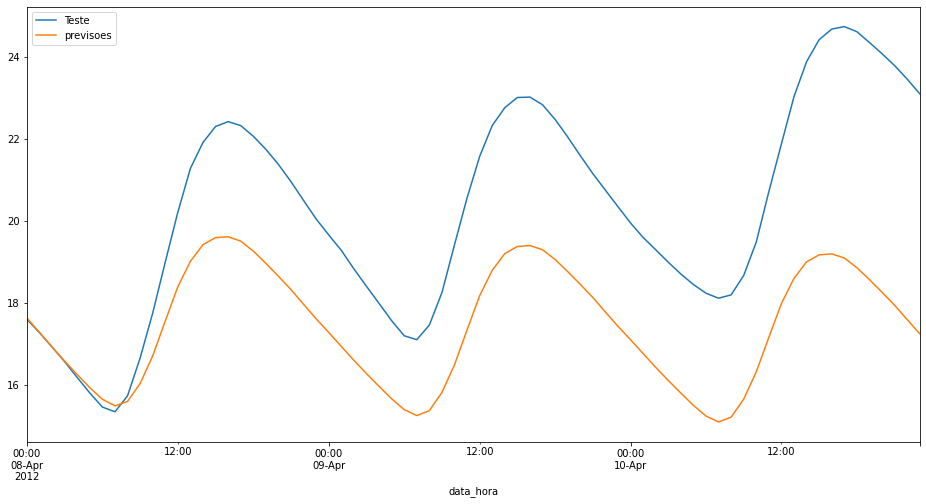

In [ ]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['previsoes'])

In [ ]:
resíduos1 = resultado1.resid

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


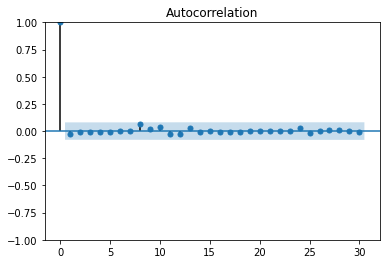

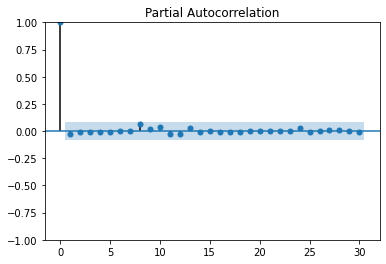

In [ ]:
plot_acf(resíduos1, lags=30)
plot_pacf(resíduos1, lags=30)
plt.show()

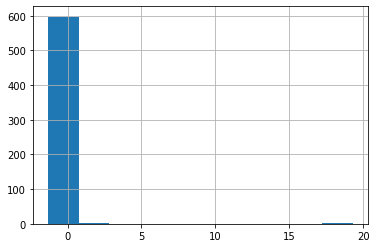

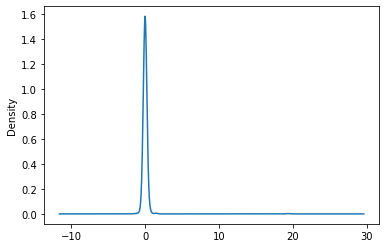

In [ ]:
resíduos1.hist()

plt.show()
resíduos1.plot(kind='kde')
plt.show()

In [ ]:
df_teste = pd.read_csv('test.csv')
df_teste['data_hora'] = df_teste.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_teste = df_teste.sort_values(by='data_hora')
df_teste = df_teste.set_index('data_hora')
#dfx = df_treino['Indoor_temperature_room'].resample('H').mean().iloc[1: , ]
#df_teste = pd.DataFrame(dfx, columns = ['Indoor_temperature_room'])
df_teste.fillna(method='ffill', inplace=True)

In [ ]:

df00 = df_teste[df_teste['Time'].str.contains(r'\d{2}\:00')]
df15 = df_teste[df_teste['Time'].str.contains(r'\d{2}\:15')]
df30 = df_teste[df_teste['Time'].str.contains(r'\d{2}\:30')]
df45 = df_teste[df_teste['Time'].str.contains(r'\d{2}\:45')]


In [ ]:
df00.shape, df15.shape, df30.shape, df45.shape

((343, 19), (344, 18), (344, 18), (342, 18))

In [ ]:
prediction00 = resultado1.predict(start=df00.index.min(), end=df00.index.max(), dynamic=False, typ='levels')
df00 = pd.merge(df00, prediction00, left_index=True, right_index=True)
prediction15 = resultado1.predict(start=df15.index.min(), end=df15.index.max(), dynamic=False, typ='levels')
df15['predicted_mean'] = prediction15.to_numpy().tolist()
prediction30 = resultado1.predict(start=df30.index.min(), end=df30.index.max(), dynamic=False, typ='levels')
df30['predicted_mean'] = prediction30.to_numpy().tolist()
prediction45 = resultado1.predict(start=df45.index.min(), end=df45.index.max(), dynamic=False, typ='levels')
df45['predicted_mean'] = prediction45.to_numpy().tolist()[:-1]

df_resultado = pd.concat([df00[['Id','predicted_mean' ]], 
                          df15[['Id','predicted_mean' ]], 
                          df30[['Id','predicted_mean' ]],
                          df45[['Id','predicted_mean' ]]], sort=False)
df_resultado = df_resultado.sort_values(by='Id')
df_resultado.columns = ['Id', 'Indoor_temperature_room']
df_resultado['Id'] = df_teste['Id'].astype('int')
df_resultado[['Id', 'Indoor_temperature_room']].to_csv('hederson_submition.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
!cat hederson_submition.csv

Id,Indoor_temperature_room
2764,15.728864920631873
2765,15.420763074663128
2766,15.420763074663128
2767,15.420763074663128
2768,15.420763074663128
2769,15.113961736759677
2770,15.113961736759677
2771,15.113961736759677
2772,15.113961736759677
2773,14.8214119408043
2774,14.8214119408043
2775,14.8214119408043
2776,14.8214119408043
2777,14.540686725686726
2778,14.540686725686726
2779,14.540686725686726
2780,14.540686725686726
2781,14.266178498436616
2782,14.266178498436616
2783,14.266178498436616
2784,14.266178498436616
2785,14.027658989938216
2786,14.027658989938216
2787,14.027658989938216
2788,14.027658989938216
2789,13.896343786134286
2790,13.896343786134286
2791,13.896343786134286
2792,13.896343786134286
2793,14.002335996956715
2794,14.002335996956715
2795,14.002335996956715
2796,14.002335996956715
2797,14.403922813819634
2798,14.403922813819634
2799,14.403922813819634
2800,14.403922813819634
2801,15.014422441021004
2802,15.014422441021004
2803,15.014422441021004
2804,15.0144224410210